<h1 align="center">Stone Soup Metrics Example</h1>
<h3 align="center">This notebook illustrates how to generate GOSPA and OSPA metrics using simulated data in StoneSoup</h3>



First we will generate test data.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Simulate 2-dimensional cartesian data.
# Let 'track_set' denote the set of tracked positions,
# and let 'truth_set' denote the set of truth positions.
# Cardinality of these sets are randomly assigned 
# integers between 5 and 15.

ndim = 2
ntracks = np.random.randint(5,15)
mtruths = np.random.randint(5,15)

track_set = 20 * (np.random.random_sample((ndim, ntracks)) - 0.5)
truth_set = 20 * (np.random.random_sample((ndim, mtruths)) - 0.5)

Next, generate GOSPA metric using the *GOSPAMetric* generator class. Also compute the assignment matrix for plotting results.

In [2]:
# Compute GOSPA
from stonesoup.metricgenerator.ospametric import GOSPAMetric
from stonesoup.types.state import State
from stonesoup.types.track import Track
from stonesoup.types.groundtruth import GroundTruthPath
from stonesoup.models.measurement.linear import LinearGaussian

from datetime import datetime, timedelta

time = datetime.now()

track_obj = Track([State(state_vector=[[track_set[0,i]], [track_set[1,i]]], timestamp=time)
                   for i in range(track_set.shape[1])])

truth_obj = GroundTruthPath([State(state_vector=[[truth_set[0,i]], [truth_set[1,i]]], timestamp=time)
                             for i in range(truth_set.shape[1])])

cutoff_distance = 8

gospa_generator = GOSPAMetric(c=cutoff_distance, p=2,
                        measurement_model_truth=LinearGaussian(2,[[0],[1]],None),
                        measurement_model_track=LinearGaussian(2,[[0],[1]],None))
gospa_cost_matrix = gospa_generator.compute_cost_matrix(track_obj.states, truth_obj.states)
gospa_metric = gospa_generator.compute_over_time(track_obj.states,
                                       truth_obj.states)
assignment_matrix = gospa_generator.compute_gospa_metric(track_obj.states,
                                       truth_obj.states)[1]

Plot GOSPA metric results.

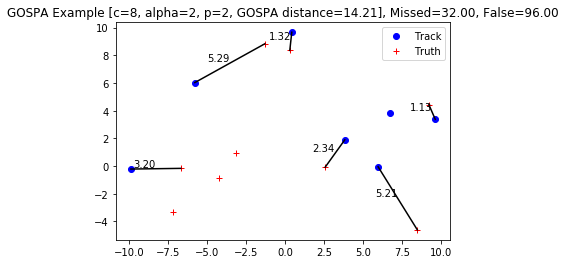

In [3]:
# Plot
fig_a = plt.plot(track_set[0,:], track_set[1,:], 'bo', truth_set[0,:], truth_set[1,:], 'r+')
truth_ind = range(0, np.max([ntracks, mtruths]))
i, j = np.where(assignment_matrix != -1)
truth_ind = [truth_ind[n] for n in j]
track_ind = assignment_matrix[0, np.argwhere(assignment_matrix != -1)[:,1]]
for ind in range(len(truth_ind)):
    db = np.min([np.sqrt(sum(np.square(track_set[:,track_ind[ind]] - truth_set[:,truth_ind[ind]]))), cutoff_distance])
    if db < cutoff_distance:
        plt.plot([track_set[0, track_ind[ind]], truth_set[0, truth_ind[ind]]], [track_set[1, track_ind[ind]], truth_set[1, truth_ind[ind]]], 'k-')
        plt.text(track_set[0, track_ind[ind]]/2.+truth_set[0, truth_ind[ind]]/2.,
                 track_set[1, track_ind[ind]]/2.+truth_set[1, truth_ind[ind]]/2., "{:.2f}".format(db), horizontalalignment='right', verticalalignment='bottom')
plt.title("GOSPA Example [c={}, alpha={}, p={}, GOSPA distance={:.2f}], Missed={:.2f}, False={:.2f}".format(gospa_generator.c, gospa_generator.alpha, gospa_generator.p, gospa_metric.value['distance'],gospa_metric.value['false'], gospa_metric.value['missed']))
plt.legend(['Track', 'Truth'])

Next, generate OSPA metric using the OSPAMetric class. Also compute the assignment matrix for plotting results.

In [4]:
# Compute OSPA
from stonesoup.metricgenerator.ospametric import OSPAMetric
from scipy.optimize import linear_sum_assignment

time = datetime.now()

track_obj = Track([State(state_vector=[[track_set[0,i]], [track_set[1,i]]], timestamp=time)
                   for i in range(track_set.shape[1])])

truth_obj = GroundTruthPath([State(state_vector=[[truth_set[0,i]], [truth_set[1,i]]], timestamp=time)
                             for i in range(truth_set.shape[1])])

cutoff_distance = 8

ospa_generator = OSPAMetric(c=cutoff_distance, p=2,
                        measurement_model_truth=LinearGaussian(2,[[0],[1]],None),
                        measurement_model_track=LinearGaussian(2,[[0],[1]],None))
ospa_metric = ospa_generator.compute_over_time(track_obj.states,
                                       truth_obj.states)
ospa_cost_matrix = ospa_generator.compute_cost_matrix(track_obj.states, truth_obj.states)
measured_to_truth, truth_to_measured = linear_sum_assignment(ospa_cost_matrix)

Plot OSPA metric results.

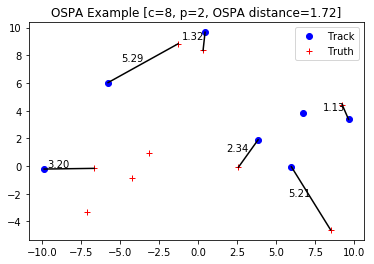

In [5]:
fig_b = plt.plot(track_set[0,:], track_set[1,:], 'bo', truth_set[0,:], truth_set[1,:], 'r+')
truth_ind = truth_to_measured
track_ind = measured_to_truth
for ind in range(len(truth_ind)):
    db = np.min([np.sqrt(sum(np.square(track_set[:,track_ind[ind]] - truth_set[:,truth_ind[ind]]))), ospa_generator.c])
    if db < cutoff_distance:
        plt.plot([track_set[0, track_ind[ind]], truth_set[0, truth_ind[ind]]], [track_set[1, track_ind[ind]], truth_set[1, truth_ind[ind]]], 'k-')
        plt.text(track_set[0, track_ind[ind]]/2.+truth_set[0, truth_ind[ind]]/2.,
                 track_set[1, track_ind[ind]]/2.+truth_set[1, truth_ind[ind]]/2., "{:.2f}".format(db), horizontalalignment='right', verticalalignment='bottom')
plt.title("OSPA Example [c={}, p={}, OSPA distance={:.2f}]".format(ospa_generator.c, ospa_generator.p, ospa_metric.value))
plt.legend(['Track', 'Truth'])